In [1]:
#Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier


from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

In [2]:
#Reading the training data
url = 'https://drive.google.com/file/d/1Op1vQftBKN1lrPVGGLJU-UOlv_dScTup/view?usp=sharing' # train.csv
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
mush_train = pd.read_csv(path)

In [3]:
#Reading the testing data
url = 'https://drive.google.com/file/d/16S9TzU3JkhwlGhXczibK9f2UbgNaHdM3/view?usp=sharing' # test.csv
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
mush_test = pd.read_csv(path)

In [ ]:
#Number of rows
mush_train.shape[0]

In [ ]:
mush_train.head()

In [ ]:
mush_train.columns

# Data Exploration

In [4]:
mush_train.drop('Id',axis=1,inplace=True)

In [5]:
#Setting Column ID as the index
mush_test.set_index('Id',inplace=True)

In [ ]:
#Checking for class imbalance- Percentage of poisonous and non poisonous in the dataset
mush_train["poisonous"].value_counts(normalize=True)

In [ ]:
#Checking for missing data in the dataset
mush_train.isnull().sum()

#Data Checks


1.   The target variable is binary and is well balanced at 51% Non Poisonous and 49% Poisonous
2.   There are no missing data in the features and target variable.
3. The dataset has no numerical columns, therefore don't need a numerical transformation pipeline
4. The dataset consists entirely of categorical features, One-hot encoding would be the approach for all features.
5. The data has 6500 entries and 6 features and the target variable.



In [6]:
#Data Splitting
X = mush_train.drop(columns=["poisonous"]).copy()
y = mush_train["poisonous"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, random_state=8)

#Pipeline

In [7]:
#Creating the pipeline

#Categorical columns
cat_col= list(X_train.select_dtypes(include=["object"]))
cat_col

categorical_pipeline = Pipeline(steps=[
    ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

full_processor = ColumnTransformer(transformers=[
    ('category', categorical_pipeline, cat_col)
])

# Modeling

# Random Forest Classifier

In [8]:
#Random Forest Classifier
rf_pipeline = Pipeline(steps=[
    ('processor',full_processor),
    ('model', RandomForestClassifier(random_state=8))
])

#hyperparameter tuning
param_grid_rf = {
    'model__n_estimators': [500],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5, 10],
}

#Gride search
grid_search_rf = GridSearchCV(rf_pipeline, param_grid_rf, scoring='recall', cv=3,n_jobs=-1)

#Fitting the model
grid_search_rf.fit(X_train, y_train)

#best parameters
best_params_rf = grid_search_rf.best_params_
best_params_rf

{'model__max_depth': 20,
 'model__min_samples_split': 2,
 'model__n_estimators': 500}

In [9]:
#testing
y_pred_rf = grid_search_rf.predict(X_test)

In [10]:
recall_rf = recall_score(y_test, y_pred_rf)
recall_rf

0.9436619718309859

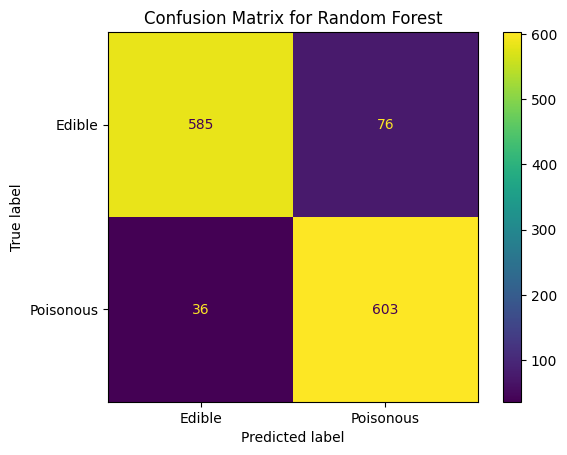

In [18]:
#Computing and displaying the confusion matrix
cm= confusion_matrix(y_test, y_pred_rf)

ConfusionMatrixDisplay(cm, display_labels=["Edible", "Poisonous"]).plot()
plt.title('Confusion Matrix for Random Forest')
plt.show();

# Decision Tree Classifier

In [19]:
#Decision tree classifier
dt_pipeline = Pipeline(steps=[
    ('processor',full_processor),
    ('model', DecisionTreeClassifier())])

#Hyperparameter tuning
param_grid_dt = {
    'model__max_depth': [None, 10,15],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
}

#Grid search
grid_search_dt = GridSearchCV(dt_pipeline, param_grid_dt, scoring='recall', cv=3, n_jobs=-1)

#Fitting the model
grid_search_dt.fit(X_train, y_train)

# Best parameters
best_params_dt = grid_search_dt.best_params_
best_params_dt

{'model__max_depth': None,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2}

In [20]:
#testing
y_pred_dt = grid_search_dt.predict(X_test)

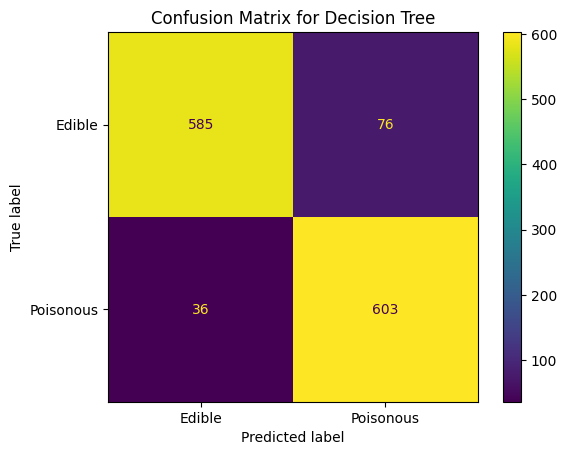

In [21]:
##Computing and displaying the confusion matrix
cm= confusion_matrix(y_test, y_pred_dt)

ConfusionMatrixDisplay(cm, display_labels=["Edible", "Poisonous"]).plot()
plt.title('Confusion Matrix for Decision Tree')
plt.show();

# Gradient Boost Classifier

In [22]:
#XGBoost Classifier
xgb_pipeline = Pipeline(steps=[
    ('processor',full_processor),
    ('model', XGBClassifier(random_state=8))
])

param_grid_xgb = {
    'model__n_estimators':[50,100],
    'model__learning_rate': [0.05, 0.1],
    'model__max_depth': [3, 5],
}

# GridSearchCV with AUC as the scoring metric
grid_search_xgb = GridSearchCV(xgb_pipeline, param_grid_xgb, scoring='recall', cv=3, n_jobs=-1)

#Fitting the model
grid_search_xgb.fit(X_train, y_train)

# Best parameters
best_params_xgb = grid_search_xgb.best_params_
best_params_xgb


{'model__learning_rate': 0.1,
 'model__max_depth': 3,
 'model__n_estimators': 100}

In [23]:
#Testing
y_pred_xgb = grid_search_xgb.predict(X_test)

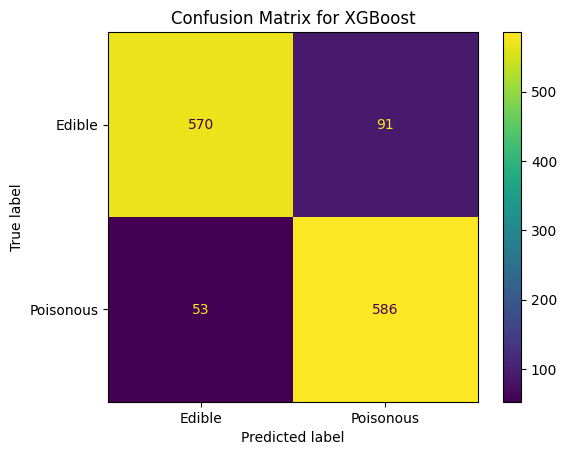

In [24]:
##Computing and displaying the confusion matrix
cm= confusion_matrix(y_test, y_pred_xgb)

ConfusionMatrixDisplay(cm, display_labels=["Edible", "Poisonous"]).plot()
plt.title('Confusion Matrix for XGBoost')
plt.show();

In [25]:
recall_rf = recall_score(y_test, y_pred_rf)
print(f"Recall for Random Forest: {recall_rf}")

# Calculate recall for Decision Tree
recall_dt = recall_score(y_test, y_pred_dt)
print(f"Recall for Decision Tree: {recall_dt}")

# Calculate recall for XGBoost
recall_xgb = recall_score(y_test, y_pred_xgb)
print(f"Recall for XGBoost: {recall_xgb}")


Recall for Random Forest: 0.9436619718309859
Recall for Decision Tree: 0.9436619718309859
Recall for XGBoost: 0.917057902973396


# ROC CURVE

In [26]:
#Predict_proba
baseline_proba=[0 for i in range(len(y_test))]
rf_pred_proba = grid_search_rf.predict_proba(X_test)[:,1]
dt_pred_proba = grid_search_dt.predict_proba(X_test)[:,1]
xgb_pred_proba = grid_search_xgb.predict_proba(X_test)[:,1]

# AUC Score
baseline_auc = roc_auc_score(y_test, baseline_proba)  # AUC Score for Baseline
rf_auc = roc_auc_score(y_test, rf_pred_proba)         # AUC Score for Random Forest
dt_auc = roc_auc_score(y_test, dt_pred_proba)         # AUC Score for Decision Tree
xgb_auc = roc_auc_score(y_test, xgb_pred_proba)       # AUC Score for XGBoost

# Print AUC Scores
print('Baseline: AUC = %.3f' % (baseline_auc))
print('Decision Tree: AUC = %.3f' % (dt_auc))
print('Random Forest: AUC = %.3f' % (rf_auc))
print('XGBoost: AUC = %.3f' % (xgb_auc))


Baseline: AUC = 0.500
Decision Tree: AUC = 0.966
Random Forest: AUC = 0.967
XGBoost: AUC = 0.955


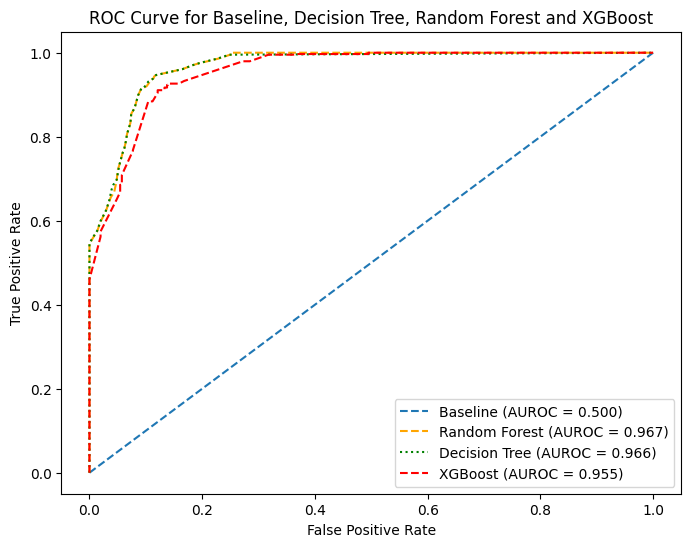

In [27]:
#ROC Curve
fpr_baseline, tpr_baseline, thresholds = roc_curve(y_test, baseline_proba)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, rf_pred_proba)
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, dt_pred_proba)
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, xgb_pred_proba)

#Plotting the curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_baseline, tpr_baseline, linestyle='--',label='Baseline (AUROC = %0.3f)' % baseline_auc)
plt.plot(fpr_rf, tpr_rf, linestyle='dashed',color='orange', label='Random Forest (AUROC = %0.3f)' % rf_auc)
plt.plot(fpr_dt, tpr_dt, linestyle='dotted',color='green', label='Decision Tree (AUROC = %0.3f)' % dt_auc)
plt.plot(fpr_xgb, tpr_xgb, linestyle='--',color='red', label='XGBoost (AUROC = %0.3f)' % xgb_auc)

#Labels
plt.title('ROC Curve for Baseline, Decision Tree, Random Forest and XGBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show();

In [28]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, rf_pred_proba)
pd.DataFrame({'FPR': fpr_rf, 'TPR': tpr_rf, 'Threshold': thresholds_rf})

/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,FPR,TPR,Threshold
0,0.000000,0.000000,inf
1,0.000000,0.336463,1.000000
2,0.000000,0.359937,0.999774
3,0.000000,0.370892,0.999427
4,0.000000,0.377152,0.999314
...,...,...,...
112,0.570348,1.000000,0.000511
113,0.574887,1.000000,0.000111
114,0.585477,1.000000,0.000093
115,0.594554,1.000000,0.000021


In [ ]:
#Submission
#y_pred_rf = grid_search_rf.predict(mush_test)

#submission_file = pd.DataFrame({
    #'Id': mush_test['Id'],
   # 'poisonous': y_pred_rf
#}).to_csv('submission7.csv', index=False)

In [29]:
# Find the threshold where TPR is 1 for each model
def find_threshold_for_tpr_1(fpr, tpr, thresholds):# Finds the threshold where TPR is 1 for a given ROC curve
  for i in range(len(tpr)):
    if tpr[i] == 1:
      return thresholds[i]
  return None  # Return None if TPR 1 is not found

threshold_rf = find_threshold_for_tpr_1(fpr_rf, tpr_rf, thresholds_rf)
threshold_dt = find_threshold_for_tpr_1(fpr_dt, tpr_dt, thresholds_dt)
threshold_xgb = find_threshold_for_tpr_1(fpr_xgb, tpr_xgb, thresholds_xgb)


print("Threshold for Random Forest where TPR is 1:", threshold_rf)
print("Threshold for Decision Tree where TPR is 1:", threshold_dt)
print("Threshold for XGBoost where TPR is 1:", threshold_xgb)


Threshold for Random Forest where TPR is 1: 0.19891292324297488
Threshold for Decision Tree where TPR is 1: 0.0
Threshold for XGBoost where TPR is 1: 0.11276898


In [30]:
predicted_proba = grid_search_rf.predict_proba(X_test)

predicted = (predicted_proba[:,1] >= threshold_rf).astype(int)

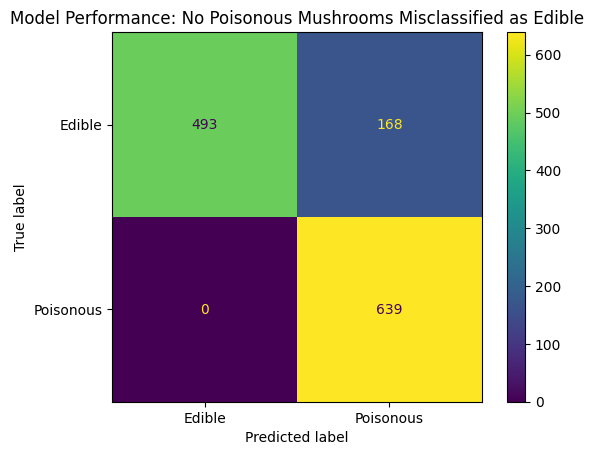

In [32]:
#Confusion Matrix
cf_matrix= confusion_matrix(y_test, predicted)

ConfusionMatrixDisplay(cf_matrix, display_labels=["Edible", "Poisonous"]).plot()
plt.title('Model Performance: No Poisonous Mushrooms Misclassified as Edible')
plt.show();

In [ ]:
#Adjusting the predictions based on threshold value - test
predicted_proba__test=grid_search_rf.predict_proba(mush_test)

In [ ]:
final_score= pd.DataFrame(predicted_proba__test[:,1]).copy()

In [ ]:
final_score[final_score[0] >= threshold_rf] = 1
final_score[final_score[0] < threshold_rf] = 0

In [ ]:

 #submission
submission_file = pd.DataFrame({'Id': mush_test['Id'], 'poisonous': final_score.iloc[:,0]}).to_csv('submission8.csv', index=False)